In [5]:
import random
import sqlite3
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats

from ISLP.models import (ModelSpec as MS,
                         summarize)

In [6]:
connect = sqlite3.connect('../data/sql/suicide_rates_overview.db')
df_origin = pd.read_sql_query("SELECT * FROM suicide_rates WHERE suicides_no>0", connect)

# gazer suicide_rate, population and cuicide_ratio per for per country, per year
# clear abnormal values
query = """SELECT country, year, total_suic_rate, country_population, 
       total_suic_rate / country_population * 100000 AS suic_rate_per100k,
       \"gdp_per_capita ($)\"
FROM (
    SELECT country, 
           year, 
           SUM(suicides_no) AS total_suic_rate, 
           SUM(population) AS country_population,
           \"gdp_per_capita ($)\"
    FROM suicide_rates
    GROUP BY country, year
) AS subquery
WHERE total_suic_rate > 0 AND total_suic_rate """
df_total_cases_per_year_country = pd.read_sql_query( query, connect)

connect.close()

df_total_cases_per_year_country

,country,year,total_suic_rate,country_population,suic_rate_per100k,gdp_per_capita ($)
0,Albania,1987,73.0,2709600,2.694125,796.000000
1,Albania,1988,63.0,2764300,2.279058,769.000000
2,Albania,1989,68.0,2803100,2.425886,833.000000
3,Albania,1992,47.0,2822500,1.665190,251.000000
4,Albania,1993,73.0,2807300,2.600363,437.000000
...,...,...,...,...,...,...
2474,Uzbekistan,2013,1950.0,26838924,7.265567,2150.000000
2475,Uzbekistan,2014,2095.0,27313507,7.670198,2309.000000
2476,Uzbekistan,2017,2417.0,388663200,0.621875,1916.764642
2477,Uzbekistan,2018,2278.0,395473200,0.576019,1597.068337


In [7]:
# geting set of countries
set_country = set()
df_country = df_total_cases_per_year_country['country']
set_country = set( df_country.T )

### Impact of GDP per Capita on Suicide Rates per 100,000 Population per Country

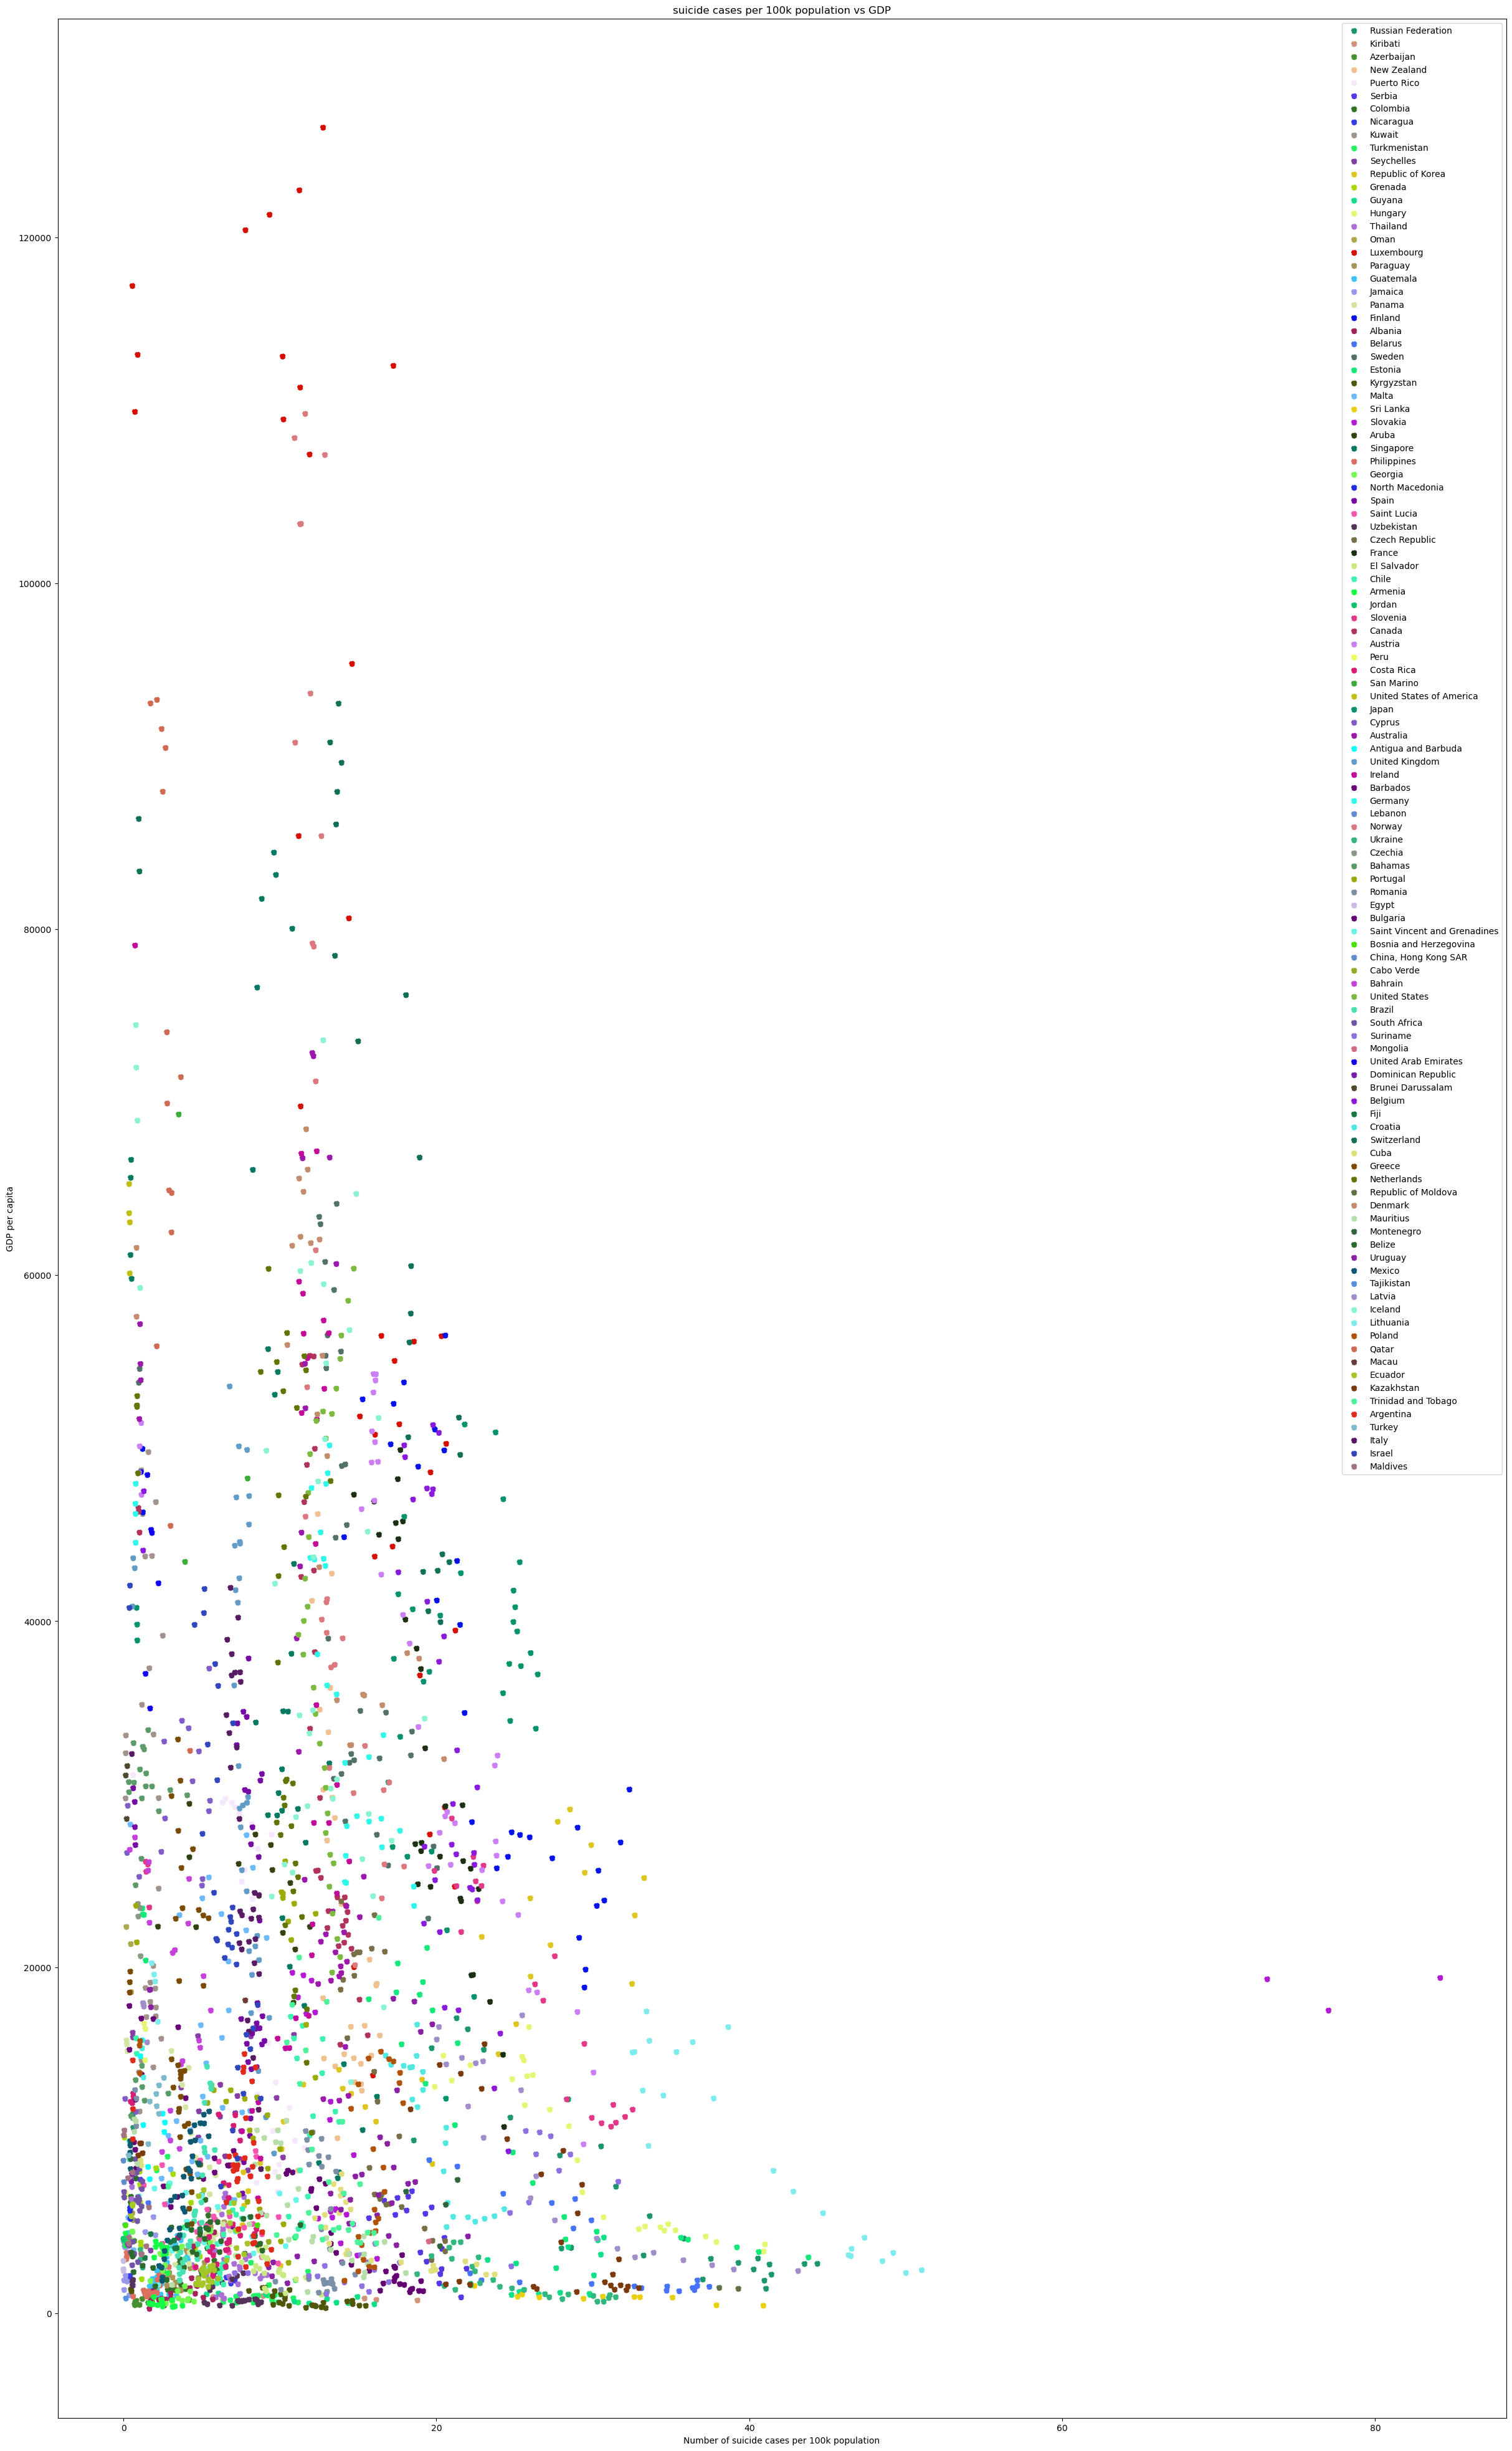

In [8]:
plt.figure(figsize=(30, 50))
title='suicide cases per 100k population vs GDP'
show_legend=True
xlabel='Number of suicide cases per 100k population'
ylabel='GDP per capita'

for country in set_country:
    df_filtered_by_country = df_total_cases_per_year_country[df_total_cases_per_year_country['country']==country]
    y=df_filtered_by_country['gdp_per_capita ($)']
    x=np.ma.masked_where(df_filtered_by_country['suic_rate_per100k'] > 100, df_filtered_by_country['suic_rate_per100k'])
    plt.scatter(x, y, color=np.random.rand(3,), linestyle='--', label=country)

# Setting the plot title and axis labels 
plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)

if show_legend:
    plt.legend()
    
plt.show()

### Preparing data for general multilinear reggression.
For 'Age' column we using One-Hot Encoding
One-hot encoding converts categorical data into binary columns for each categorical variables without an inherent order. It avoids implying any ordinal relationship.

For 'sex' column we will use binary as well 0-female, 1-male.


In [9]:
def categorize (value, target_value):
    if value in target_value:
        return 1    
    else:
        return 0

enc_dict = {'male':'sex', '5-14 years':'age', '15-24 years':'age', '25-34 years':'age', '35-54 years':'age', '55-74 years':'age', '75+ years':'age'}
for key, value in enc_dict.items():
    df_origin[key] = df_origin[value].apply(categorize, target_value=key)

In [10]:
df_origin['suicides/100k pop']


0        6.710000
1        5.190000
2        4.830000
3        4.590000
4        3.280000
           ...   
25975    0.571032
25976    0.157435
25977    0.154096
25978    0.409094
25979    0.009263
Name: suicides/100k pop, Length: 25980, dtype: float64

In [18]:
def fit_model(df):
    # drop columns
    pred_stand=df.drop(['country','sex','suicides_no', 'population','age','country-year', 'suicides/100k pop', 'HDI for year', ' gdp_for_year ($) ', 'generation'],axis=1)
    
    scaler = StandardScaler()                         
    pred_stand = pd.DataFrame(scaler.fit_transform(pred_stand) , columns=pred_stand.columns ) # normilize
    pred_stand['gdp_per_capita:sex'] = pred_stand['gdp_per_capita ($)'] * pred_stand['male']

    pred_stand = MS(pred_stand.columns).fit_transform(pred_stand)
    df = df.reset_index(drop=True)
    y = df['suicides/100k pop']
    # split data on train/test
   # X_train, X_test, y_train, y_test = train_test_split ( X, y, test_size=0.2, random_state=0)
    random_state = np.random.RandomState(seed=0)
    split = random_state.choice([True, False], size=len(pred_stand), replace=True, p=[0.8, 0.2])
    X_train = pred_stand[split]
    X_test = pred_stand[~split]
    y_train = df.loc[split, 'suicides/100k pop']
    y_test = df.loc[~split, 'suicides/100k pop']

    # training model
    reggr_model = sm.OLS( y_train, X_train )
    reggr_result = reggr_model.fit()
    print(reggr_result.summary())
    return [reggr_result, X_train, X_test, y_train, y_test]

reggr_result, X_train, X_test, y_train, y_test = fit_model(df_origin)


                            OLS Regression Results                            
Dep. Variable:      suicides/100k pop   R-squared:                       0.230
Model:                            OLS   Adj. R-squared:                  0.229
Method:                 Least Squares   F-statistic:                     688.1
Date:                Wed, 26 Jun 2024   Prob (F-statistic):               0.00
Time:                        11:14:06   Log-Likelihood:                -91800.
No. Observations:               20772   AIC:                         1.836e+05
Df Residuals:                   20762   BIC:                         1.837e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
intercept             14.2508      0

c:\Users\Igor\.conda\envs\dsi_participant\lib\site-packages\ISLP\models\columns.py:159: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if is_categorical[i]:


In [19]:
# Predicting
y_reggr_pred = reggr_result.predict( X_test )
y_reggr_pred

7         7.873564
8        28.632357
13       28.390598
17       23.599318
19       37.877153
           ...    
25963    17.390653
25964    15.173447
25970    15.454888
25976    17.274767
25978    16.094060
Length: 5208, dtype: float64

In [20]:
# Root Mean Squared Error (RMSE)
# The square root of the average of squared differences between prediction and actual observation.
rmse = np.sqrt(mean_squared_error(y_test, y_reggr_pred))
print(f'Root Mean Squared Error (RMSE) {rmse:.2f}' )

# Mean Squared Log Error (MSLE)
# Measures the ratio between the true and predicted values.
msle = mean_squared_log_error(abs(y_test), abs(y_reggr_pred))
print(f'Mean Squared Log Error (MSLE) {msle:.2f}')

Root Mean Squared Error (RMSE) 20.92
Mean Squared Log Error (MSLE) 1.28


The average model error is 21.68 units for the suicide ratio (suicide cases per 100,000 population). This high error may be influenced by outliers in the data. All predictors have a p-value < 0.05, indicating that we reject the null hypothesis that these predictors have no effect on the suicide ratio.

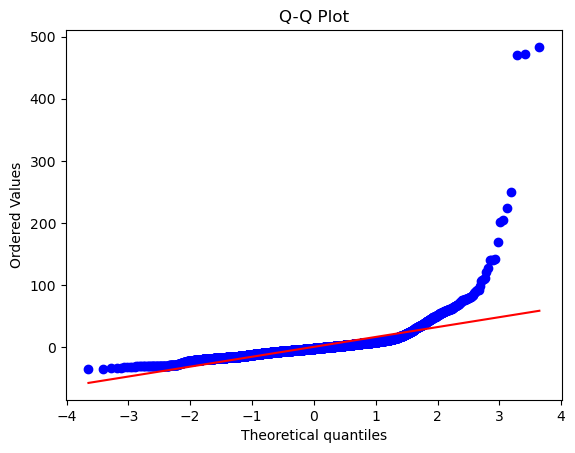

In [21]:
# Residuals
residuals = y_test - y_reggr_pred

# Q-Q plot check if residuals follow a normal distribution
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot")
plt.show()

### Reducing error by removing outliers

In [22]:

df_origin_updated = df_origin.loc[df_origin['suicides/100k pop'] < 60]
reggr_result_upd, X_train, X_test, y_train, y_test = fit_model(df_origin_updated)

                            OLS Regression Results                            
Dep. Variable:      suicides/100k pop   R-squared:                       0.362
Model:                            OLS   Adj. R-squared:                  0.362
Method:                 Least Squares   F-statistic:                     1257.
Date:                Wed, 26 Jun 2024   Prob (F-statistic):               0.00
Time:                        11:14:21   Log-Likelihood:                -73639.
No. Observations:               19912   AIC:                         1.473e+05
Df Residuals:                   19902   BIC:                         1.474e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
intercept             10.9197      0

c:\Users\Igor\.conda\envs\dsi_participant\lib\site-packages\ISLP\models\columns.py:159: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if is_categorical[i]:


Root Mean Squared Error (RMSE) 9.90
Mean Squared Log Error (MSLE) 0.93
Predictor mean 14.32


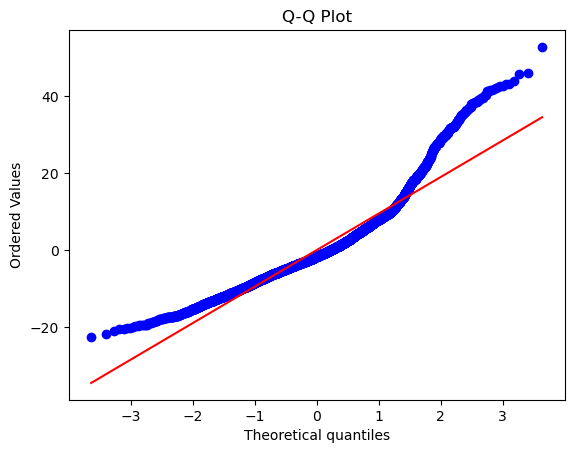

In [38]:
# Predicting
y_reggr_pred = reggr_result_upd.predict( X_test )

# Root Mean Squared Error (RMSE)
# The square root of the average of squared differences between prediction and actual observation.
rmse = np.sqrt(mean_squared_error(y_test, y_reggr_pred))
print(f'Root Mean Squared Error (RMSE) {rmse:.2f}' )

# Mean Squared Log Error (MSLE)
# Measures the ratio between the true and predicted values.
msle = mean_squared_log_error(abs(y_test), abs(y_reggr_pred))
print(f'Mean Squared Log Error (MSLE) {msle:.2f}')

mean = np.mean(df_origin['suicides/100k pop'])
print(f'Predictor mean {mean:.2f}')

# Residuals
residuals = y_test - y_reggr_pred

# Q-Q plot check if residuals follow a normal distribution
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot")
plt.show()

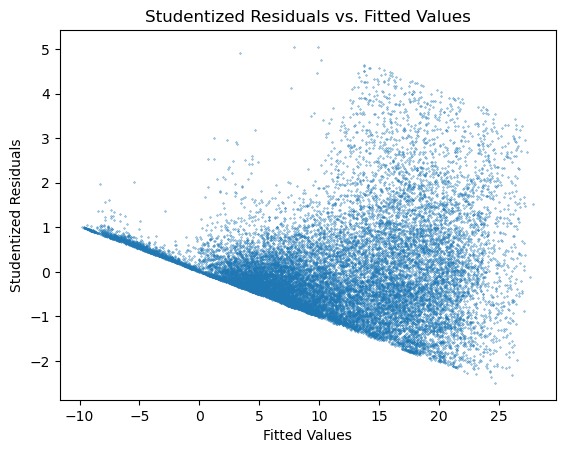

In [37]:
# Get the predicted values and studentized residuals
predicted_values = reggr_result_upd.predict()
studentized_residuals = reggr_result_upd.get_influence().resid_studentized_internal

# Plot the Studentized Residuals vs. Fitted Values
plt.scatter(predicted_values, studentized_residuals, s=1, marker='x', alpha=0.4)
plt.xlabel('Fitted Values')
plt.ylabel('Studentized Residuals')
plt.title('Studentized Residuals vs. Fitted Values')
plt.show()

Studentized Residuals vs. Fitted Values plot shows presents of outliers, our model not idealy fit but could be acceptable because of low p-value and not very high errors. 